### Importing the necessary libraries

In [1]:
import yfinance as yf

In [2]:
sony_info = yf.Ticker("SONY")
sony_history = sony_info.history(period="max")

In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [33]:
# CONSTANT PARAMETERS
EPOCH_COUNT = 40
BATCH_SIZE = 32

### Plot closing price data over time

In [6]:
# Get closing price column from the dataframe
closing_price_data = sony_history.iloc[:,3:4]
closing_price_data = closing_price_data.rename(columns={"Close": "Closing Price"})
closing_price_data.head()

,Closing Price
Date,
1973-02-21 00:00:00-05:00,5.828178
1973-02-22 00:00:00-05:00,5.691689
1973-02-23 00:00:00-05:00,5.582495
1973-02-26 00:00:00-05:00,5.500597
1973-02-27 00:00:00-05:00,5.377756


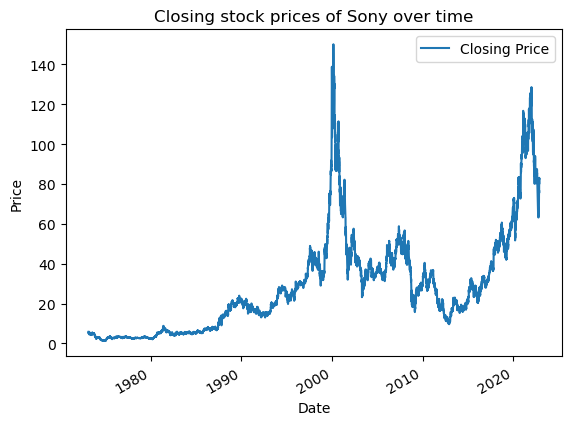

In [34]:
# Plot the closing stock price data
closing_price_data.plot()
plt.ylabel("Price")
plt.title("Closing stock prices of Sony over time")
plt.show()

### Scale the data

In [8]:
# Scale the data using Min-Max scaling to reduce computational cost.
scaler = MinMaxScaler()
closing_price_data_scaled = scaler.fit_transform(closing_price_data)

# The following logical comparison concludes that there are no NaN values.
len(closing_price_data.isna()) == len(closing_price_data)
closing_price_data_scaled_df = pd.DataFrame(closing_price_data_scaled)
closing_price_data_scaled_df.index = closing_price_data.index
closing_price_data_scaled_df = closing_price_data_scaled_df.rename(columns={0:"Closing Price"})
closing_price_data_scaled_df.head()

,Closing Price
Date,
1973-02-21 00:00:00-05:00,0.031057
1973-02-22 00:00:00-05:00,0.030140
1973-02-23 00:00:00-05:00,0.029407
1973-02-26 00:00:00-05:00,0.028857
1973-02-27 00:00:00-05:00,0.028032


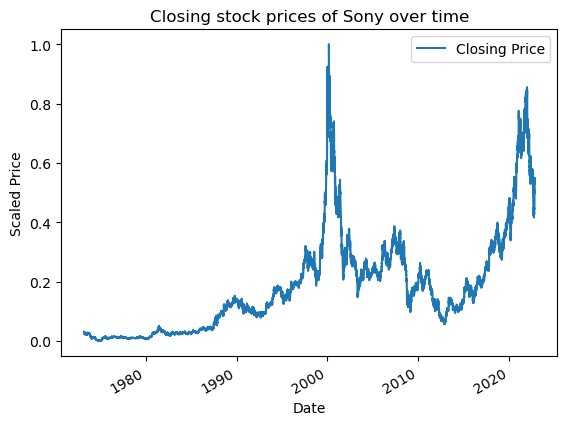

In [9]:
# Plot the scaled closing stock price data
closing_price_data_scaled_df.plot()
plt.ylabel("Scaled Price")
plt.title("Closing stock prices of Sony over time")
plt.show()

### Creation of train data and label sequences

In [10]:
# Function to generate train sample and test label sequences
def get_data_splits(data, train_size = 20, label_count = 1):
    train_sets = np.empty((0, train_size))
    labels = np.empty((0, label_count))
    length = len(data)
    for i in range(0, length):
        if (i + train_size) >= length:
            break
        # # ----------Debugging code start-----------------------------------------
        # print("Train: ", i, "to", i + train_size - 1)
        # print("Predict: ", (i + train_size), "to",
        #       (i + train_size + label_count - 1))
        # # ----------Debugging code end-------------------------------------------
        train_sets = np.append(
            train_sets, [data[i:(i + train_size)].reshape(train_size,)], axis=0)
        labels = np.append(labels, [data[(
            i + train_size):(i + train_size + label_count)].reshape(label_count,)], axis=0)

    return train_sets.reshape(len(train_sets), train_size, 1), labels.reshape(len(labels), label_count, 1)


In [11]:
# Splitting the dataset
length = len(closing_price_data_scaled)
train_sample_count = round(0.60 * length)
remaining_sample_count = length - train_sample_count
val_sample_count = round(0.50 * remaining_sample_count)

training_set = closing_price_data_scaled[0:train_sample_count]
validation_set = closing_price_data_scaled[train_sample_count:(
    train_sample_count + val_sample_count)]
testing_set = closing_price_data_scaled[(
    train_sample_count + val_sample_count):length]

In [12]:
len(training_set), len(validation_set), len(testing_set)

(7529, 2510, 2510)

In [13]:
# Get the train features, train labels, test features, test labels
train_size = 20
label_count = 1
X_train, y_train = get_data_splits(training_set, train_size, label_count)
X_val, y_val = get_data_splits(validation_set, train_size, label_count)
X_test, y_test = get_data_splits(testing_set, train_size, label_count)

print(len(X_train), len(y_train))
print(len(X_val), len(y_val))
print(len(X_test), len(y_test))

7509 7509
2490 2490
2490 2490


### Some helper functions

In [14]:
def plot_training_history(fitted_model):
    # Training/validation loss and accuracy curve
    pd.DataFrame(fitted_model.history).plot()
    plt.xlabel("Number of epochs")
    plt.ylabel("Loss - Accuracy")
    plt.tight_layout()
    plt.show()

def plot_result(y_train, y_test, train_predict, test_predict):
    actual = np.append(y_train, y_test)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 8), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(y_train), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Days')
    plt.ylabel('Stock price')
    plt.title(
        'Actual and Predicted Values. The Red Line Separates The Training And Test Examples')


### Base LSTM creation

In [15]:
def create_base_lstm(hidden_units, dense_units, input_shape, activation, lr=0.001):
    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=input_shape,
                        activation=activation))
    model.add(Dense(units=dense_units, activation=activation))
    model.compile(loss='mean_squared_error',
                  optimizer=keras.optimizers.Adam(learning_rate=lr))
    return model

n_hidden_units = 64
n_dense_units = 1
input_shape = (train_size, 1)

In [16]:
# Create base LSTM
simple_lstm = create_base_lstm(n_hidden_units, n_dense_units,
                         input_shape, activation='tanh')
simple_lstm.summary()

# Training the base LSTM
with tf.device('/cpu:0'):
    fitted_simple_lstm = simple_lstm.fit(
        X_train, y_train, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCH_COUNT)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40


2022-11-19 16:28:00.655469: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-19 16:28:00.655569: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-11-19 16:28:00.840990: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-19 16:28:01.257558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


234/235 [============================>.] - ETA: 0s - loss: 0.0016

2022-11-19 16:28:03.159842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 3s 8ms/step - loss: 0.0016 - val_loss: 1.1203e-04
Epoch 2/40
235/235 [==============================] - 2s 7ms/step - loss: 1.9635e-04 - val_loss: 1.1758e-04
Epoch 3/40
235/235 [==============================] - 2s 7ms/step - loss: 1.8416e-04 - val_loss: 1.0115e-04
Epoch 4/40
235/235 [==============================] - 2s 7ms/step - loss: 1.5991e-04 - val_loss: 8.7238e-05
Epoch 5/40
235/235 [==============================] - 2s 7ms/step - loss: 1.6294e-04 - val_loss: 6.9689e-05
Epoch 6/40
235/235 [==============================] - 2s 7ms/step - loss: 1.3833e-04 - val_loss: 7.5668e-05
Epoch 7/40
235/235 [==============================] - 2s 7ms/step - loss: 1.2520e-04 - val_loss: 6.4905e-05
Epoch 8/40
235/235 [==============================] - 2s 7ms/step - loss: 1.0824e-04 - val_loss: 6.2961e-05
Epoch 9/40
235/235 [==============================] - 2s 7ms/step - loss: 1.0378e-04 - val_loss: 6.2013e-05
Epoch 10/40
235/235 [======================

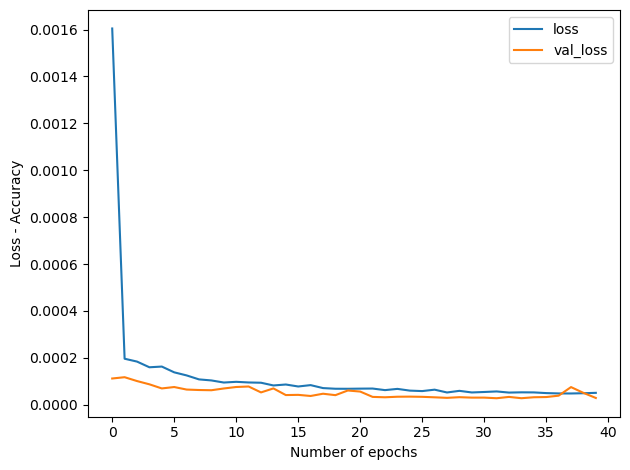

In [35]:
plot_training_history(fitted_simple_lstm)

 40/235 [====>.........................] - ETA: 0s

2022-11-19 16:29:11.690931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - 0s 3ms/step


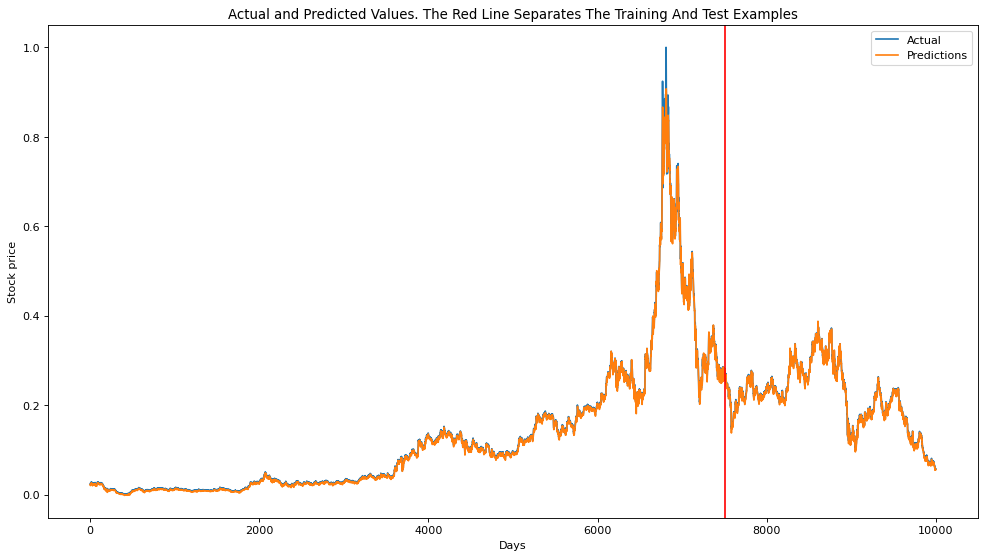

In [18]:
# Plotting actual stock prices and predictions
with tf.device('/cpu:0'):
    train_predict_simple_lstm = fitted_simple_lstm.model.predict(X_train)
    val_predict_simple_lstm = fitted_simple_lstm.model.predict(X_val)
plot_result(y_train, y_val, train_predict_simple_lstm, val_predict_simple_lstm)

### Experimentation on simple LSTM

##### Adding more layers

In [19]:
# Creating RNN with multiple layers
def create_LSTM_1(hidden_units_list, dense_units, input_shape, activation, lr=0.001):
    model = Sequential()
    model.add(LSTM(hidden_units_list[0], input_shape=input_shape,
                        activation=activation, return_sequences=True))
    for i in range(1, len(hidden_units_list)):
        if i == len(hidden_units_list) - 1:
            model.add(LSTM(hidden_units_list[i], activation=activation,
                      return_sequences=False))
        else:
            model.add(LSTM(hidden_units_list[i], activation=activation,
                      return_sequences=True))

    model.add(Dense(units=dense_units, activation=activation))
    model.compile(loss='mean_squared_error',
                  optimizer=keras.optimizers.Adam(learning_rate=lr))
    return model

n_hidden_units_list = [64, 64, 64]
n_dense_units = 1
input_shape = (train_size, 1)

In [20]:
lstm_1 = create_LSTM_1(n_hidden_units_list, n_dense_units,
                   input_shape, activation='tanh')
lstm_1.summary()

# Training the RNN with multiple SimpleRNN layers
with tf.device('/cpu:0'):
    fitted_lstm_1 = lstm_1.fit(X_train, y_train, validation_data=(
        X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCH_COUNT)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 20, 64)            16896     
                                                                 
 lstm_2 (LSTM)               (None, 20, 64)            33024     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 83,009
Trainable params: 83,009
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40


2022-11-19 16:29:14.138248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


233/235 [============================>.] - ETA: 0s - loss: 0.0010

2022-11-19 16:29:19.306570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 7s 22ms/step - loss: 0.0010 - val_loss: 2.8484e-04
Epoch 2/40
235/235 [==============================] - 5s 20ms/step - loss: 3.9306e-04 - val_loss: 1.8899e-04
Epoch 3/40
235/235 [==============================] - 5s 20ms/step - loss: 2.6909e-04 - val_loss: 3.3735e-04
Epoch 4/40
235/235 [==============================] - 5s 20ms/step - loss: 2.1208e-04 - val_loss: 9.9520e-05
Epoch 5/40
235/235 [==============================] - 5s 20ms/step - loss: 1.6253e-04 - val_loss: 1.1046e-04
Epoch 6/40
235/235 [==============================] - 5s 20ms/step - loss: 1.6160e-04 - val_loss: 1.9608e-04
Epoch 7/40
235/235 [==============================] - 5s 20ms/step - loss: 1.3422e-04 - val_loss: 7.4836e-05
Epoch 8/40
235/235 [==============================] - 5s 20ms/step - loss: 1.1148e-04 - val_loss: 9.0877e-05
Epoch 9/40
235/235 [==============================] - 5s 20ms/step - loss: 1.0925e-04 - val_loss: 7.3039e-05
Epoch 10/40
235/235 [=============

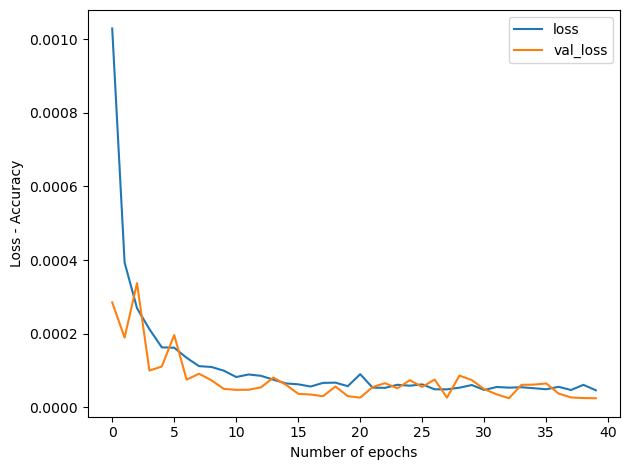

In [36]:
plot_training_history(fitted_lstm_1)


  1/235 [..............................] - ETA: 1:37

2022-11-19 16:32:22.602864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - 0s 6ms/step


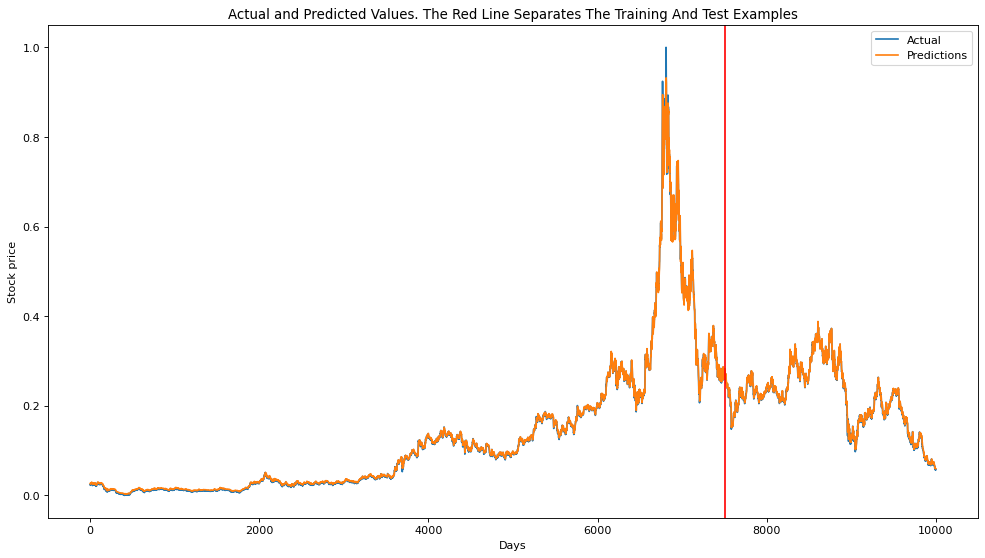

In [22]:
# Plotting actual stock prices and predictions
with tf.device('/cpu:0'):
    train_predict_lstm_1 = fitted_lstm_1.model.predict(X_train)
    val_predict_lstm_1 = fitted_lstm_1.model.predict(X_val)
plot_result(y_train, y_val, train_predict_lstm_1, val_predict_lstm_1)


##### Experimenting with the activation function and learning rate scheduling techniques.

In [23]:
import math

# Function to experiment with optimizer and learning rate.
def create_LSTM_2(hidden_units, dense_units, input_shape, activation, optimizer="Adam"):
    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=input_shape,
                        activation=activation))
    model.add(Dense(units=dense_units, activation=activation))

    optimizing_function = 0
    if optimizer == "Adam":
        optimizing_function = keras.optimizers.Adam()
    else:
        optimizing_function = keras.optimizers.RMSprop()

    model.compile(loss='mean_squared_error',
                  optimizer=optimizing_function)
    return model


initial_learning_rate = 0.01
time_decay = initial_learning_rate / EPOCH_COUNT

# Step decay for learning rate
def step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 10.0
    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))

# Exponential decay for learning rate
def exp_decay(epoch, lr):
    k = 0.1
    return initial_learning_rate * math.exp(-k*epoch)


callbacks_decay = [keras.callbacks.LearningRateScheduler(step_decay, verbose=1),
    keras.callbacks.LearningRateScheduler(exp_decay, verbose=1)]
callback_decay_keys = ["constant", "step_decay", "exp_decay"]

In [41]:
'''
Running the simple LSTM model with RMSProp and Adam with 3 different types of learning rate
scheduling.
'''
n_hidden_units = 64
n_dense_units = 1
results_simple_lstm = []
optimizers = ["Adam", "RMSProp"]
for optimizer in optimizers:
    for i, callback_decay_key in enumerate(callback_decay_keys):
        model = create_LSTM_2(n_hidden_units, n_dense_units,
                            input_shape, activation='tanh', optimizer=optimizer)
        # Training the RNN with multiple SimpleRNN layers
        fitted_model = 0
        with tf.device('/cpu:0'):
            if i == 0:
                fitted_model = model.fit(X_train, y_train, validation_data=(
                    X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCH_COUNT)
            else:
                fitted_model = model.fit(X_train, y_train, validation_data=(
                    X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCH_COUNT, callbacks=[callbacks_decay[i - 1]])

        predictions = fitted_model.model.predict(X_val)
        val_mse = mean_squared_error(
            y_val.reshape(y_val.shape[0], 1), predictions)
        results_simple_lstm.append(
            (optimizer, callback_decay_keys[i], val_mse))


Epoch 1/40


2022-11-19 19:34:39.757827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


232/235 [============================>.] - ETA: 0s - loss: 0.0012

2022-11-19 19:34:42.073097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 3s 10ms/step - loss: 0.0012 - val_loss: 1.1152e-04
Epoch 2/40
235/235 [==============================] - 2s 9ms/step - loss: 1.9991e-04 - val_loss: 9.3653e-05
Epoch 3/40
235/235 [==============================] - 2s 9ms/step - loss: 1.7981e-04 - val_loss: 8.9921e-05
Epoch 4/40
235/235 [==============================] - 2s 9ms/step - loss: 1.5567e-04 - val_loss: 9.4389e-05
Epoch 5/40
235/235 [==============================] - 2s 9ms/step - loss: 1.5324e-04 - val_loss: 7.6079e-05
Epoch 6/40
235/235 [==============================] - 2s 9ms/step - loss: 1.3130e-04 - val_loss: 5.6938e-05
Epoch 7/40
235/235 [==============================] - 2s 9ms/step - loss: 1.1379e-04 - val_loss: 5.3822e-05
Epoch 8/40
235/235 [==============================] - 2s 9ms/step - loss: 1.1114e-04 - val_loss: 6.1996e-05
Epoch 9/40
235/235 [==============================] - 2s 9ms/step - loss: 9.8006e-05 - val_loss: 7.5594e-05
Epoch 10/40
235/235 [=====================

2022-11-19 19:36:05.787579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 19:36:05.839295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - 2s 7ms/step

Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/40


2022-11-19 19:36:08.642398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - ETA: 0s - loss: 0.0012

2022-11-19 19:36:10.922305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 3s 10ms/step - loss: 0.0012 - val_loss: 1.2692e-04 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/40
235/235 [==============================] - 2s 9ms/step - loss: 1.3796e-04 - val_loss: 4.3268e-05 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.01.
Epoch 3/40
235/235 [==============================] - 2s 9ms/step - loss: 1.1278e-04 - val_loss: 4.4966e-05 - lr: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.01.
Epoch 4/40
235/235 [==============================] - 2s 9ms/step - loss: 9.1295e-05 - val_loss: 9.2542e-05 - lr: 0.0100

Epoch 5: LearningRateScheduler setting learning rate to 0.01.
Epoch 5/40
235/235 [==============================] - 2s 9ms/step - loss: 9.4762e-05 - val_loss: 3.8065e-05 - lr: 0.0100

Epoch 6: LearningRateScheduler setting learning rate to 0.01.
Epoch 6/40
235/235 [==============================] - 2s 9ms/step - loss: 9.0351e-05 - val_los

2022-11-19 19:37:34.767415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 19:37:34.813567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - 1s 6ms/step

Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/40


2022-11-19 19:37:35.931941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - ETA: 0s - loss: 3.5377e-04

2022-11-19 19:37:38.196650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 3s 10ms/step - loss: 3.5377e-04 - val_loss: 1.2201e-04 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009048374180359595.
Epoch 2/40
235/235 [==============================] - 2s 9ms/step - loss: 1.1886e-04 - val_loss: 3.8558e-05 - lr: 0.0090

Epoch 3: LearningRateScheduler setting learning rate to 0.008187307530779819.
Epoch 3/40
235/235 [==============================] - 2s 9ms/step - loss: 1.0857e-04 - val_loss: 2.7899e-05 - lr: 0.0082

Epoch 4: LearningRateScheduler setting learning rate to 0.007408182206817179.
Epoch 4/40
235/235 [==============================] - 2s 9ms/step - loss: 8.7436e-05 - val_loss: 3.9871e-05 - lr: 0.0074

Epoch 5: LearningRateScheduler setting learning rate to 0.006703200460356393.
Epoch 5/40
235/235 [==============================] - 2s 9ms/step - loss: 7.1876e-05 - val_loss: 4.9772e-05 - lr: 0.0067

Epoch 6: LearningRateScheduler setting learning rate to 0.006065306597126334.
Epoch 6/40

2022-11-19 19:39:00.910358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 19:39:00.956999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - 1s 6ms/step
Epoch 1/40


2022-11-19 19:39:02.040051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


232/235 [============================>.] - ETA: 0s - loss: 6.8469e-04

2022-11-19 19:39:04.704790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 4s 11ms/step - loss: 6.7835e-04 - val_loss: 1.3678e-04
Epoch 2/40
235/235 [==============================] - 2s 11ms/step - loss: 2.4621e-04 - val_loss: 2.3273e-04
Epoch 3/40
235/235 [==============================] - 2s 10ms/step - loss: 1.8478e-04 - val_loss: 4.9723e-05
Epoch 4/40
235/235 [==============================] - 3s 11ms/step - loss: 1.5077e-04 - val_loss: 3.3866e-04
Epoch 5/40
235/235 [==============================] - 2s 10ms/step - loss: 1.4088e-04 - val_loss: 2.0686e-04
Epoch 6/40
235/235 [==============================] - 2s 10ms/step - loss: 1.2485e-04 - val_loss: 8.4493e-05
Epoch 7/40
235/235 [==============================] - 2s 10ms/step - loss: 1.1514e-04 - val_loss: 5.1828e-04
Epoch 8/40
235/235 [==============================] - 2s 11ms/step - loss: 1.0441e-04 - val_loss: 9.3979e-05
Epoch 9/40
235/235 [==============================] - 2s 11ms/step - loss: 1.0450e-04 - val_loss: 1.2693e-04
Epoch 10/40
235/235 [=========

2022-11-19 19:40:42.222216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 19:40:42.265332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - 1s 6ms/step

Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/40


2022-11-19 19:40:43.340172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - ETA: 0s - loss: 0.0027

2022-11-19 19:40:45.941515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 3s 11ms/step - loss: 0.0027 - val_loss: 0.0023 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/40
235/235 [==============================] - 2s 10ms/step - loss: 5.3382e-04 - val_loss: 1.5303e-04 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.01.
Epoch 3/40
235/235 [==============================] - 2s 10ms/step - loss: 3.6978e-04 - val_loss: 3.5401e-04 - lr: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.01.
Epoch 4/40
235/235 [==============================] - 2s 10ms/step - loss: 2.6371e-04 - val_loss: 1.7180e-04 - lr: 0.0100

Epoch 5: LearningRateScheduler setting learning rate to 0.01.
Epoch 5/40
235/235 [==============================] - 2s 10ms/step - loss: 2.4677e-04 - val_loss: 2.3555e-04 - lr: 0.0100

Epoch 6: LearningRateScheduler setting learning rate to 0.01.
Epoch 6/40
235/235 [==============================] - 2s 10ms/step - loss: 1.9722e-04 - val_lo

2022-11-19 19:42:20.653462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 19:42:20.711534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - 1s 6ms/step

Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/40


2022-11-19 19:42:21.824095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


233/235 [============================>.] - ETA: 0s - loss: 0.0026

2022-11-19 19:42:24.389501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 3s 11ms/step - loss: 0.0026 - val_loss: 5.1623e-04 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009048374180359595.
Epoch 2/40
235/235 [==============================] - 2s 10ms/step - loss: 4.5466e-04 - val_loss: 3.3259e-05 - lr: 0.0090

Epoch 3: LearningRateScheduler setting learning rate to 0.008187307530779819.
Epoch 3/40
235/235 [==============================] - 2s 10ms/step - loss: 2.7024e-04 - val_loss: 5.3755e-04 - lr: 0.0082

Epoch 4: LearningRateScheduler setting learning rate to 0.007408182206817179.
Epoch 4/40
235/235 [==============================] - 2s 10ms/step - loss: 1.8626e-04 - val_loss: 3.7363e-04 - lr: 0.0074

Epoch 5: LearningRateScheduler setting learning rate to 0.006703200460356393.
Epoch 5/40
235/235 [==============================] - 2s 10ms/step - loss: 1.4405e-04 - val_loss: 2.2979e-05 - lr: 0.0067

Epoch 6: LearningRateScheduler setting learning rate to 0.006065306597126334.
Epoch 6/40

2022-11-19 19:44:03.493828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 19:44:03.542758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - 1s 6ms/step


In [42]:
df = pd.DataFrame(results_simple_lstm, columns=[
                  "Optimizer", "Decay type", "Val MSE"])
df

,Optimizer,Decay type,Val MSE
0,Adam,constant,0.000026
1,Adam,step_decay,0.000027
2,Adam,exp_decay,0.000023
3,RMSProp,constant,0.000037
4,RMSProp,step_decay,0.000025
5,RMSProp,exp_decay,0.000022


In [43]:
# Based on the above results, RMSProp with either of step decay or exp decay were the best
optimized_lstm_2 = create_LSTM_2(n_hidden_units, n_dense_units,
                                 input_shape, activation='tanh', optimizer=keras.optimizers.RMSprop())

with tf.device('/cpu:0'):
    fitted_optimized_lstm_2 = optimized_lstm_2.fit(X_train, y_train, validation_data=(
        X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCH_COUNT, callbacks=[callbacks_decay[1]])



Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/40


2022-11-19 19:44:05.065703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


233/235 [============================>.] - ETA: 0s - loss: 0.0029

2022-11-19 19:44:07.741575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 4s 11ms/step - loss: 0.0029 - val_loss: 0.0049 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009048374180359595.
Epoch 2/40
235/235 [==============================] - 3s 11ms/step - loss: 4.7203e-04 - val_loss: 3.2846e-04 - lr: 0.0090

Epoch 3: LearningRateScheduler setting learning rate to 0.008187307530779819.
Epoch 3/40
235/235 [==============================] - 3s 11ms/step - loss: 2.6675e-04 - val_loss: 3.2973e-05 - lr: 0.0082

Epoch 4: LearningRateScheduler setting learning rate to 0.007408182206817179.
Epoch 4/40
235/235 [==============================] - 3s 11ms/step - loss: 1.9136e-04 - val_loss: 3.7906e-05 - lr: 0.0074

Epoch 5: LearningRateScheduler setting learning rate to 0.006703200460356393.
Epoch 5/40
235/235 [==============================] - 3s 11ms/step - loss: 1.4857e-04 - val_loss: 1.3332e-04 - lr: 0.0067

Epoch 6: LearningRateScheduler setting learning rate to 0.006065306597126334.
Epoch 6/40
235

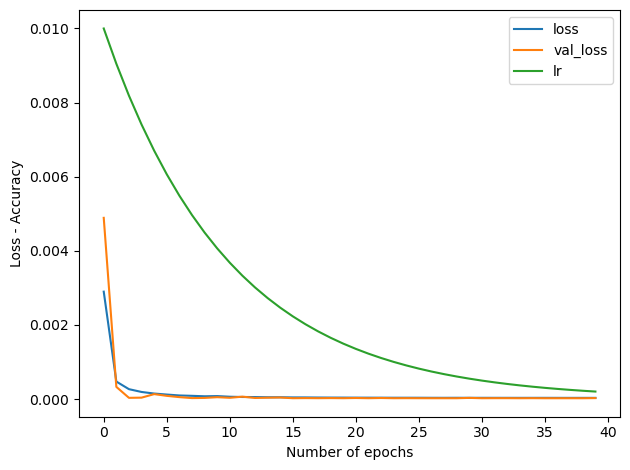

In [44]:
plot_training_history(fitted_optimized_lstm_2)

78/78 [==============================] - 0s 3ms/step


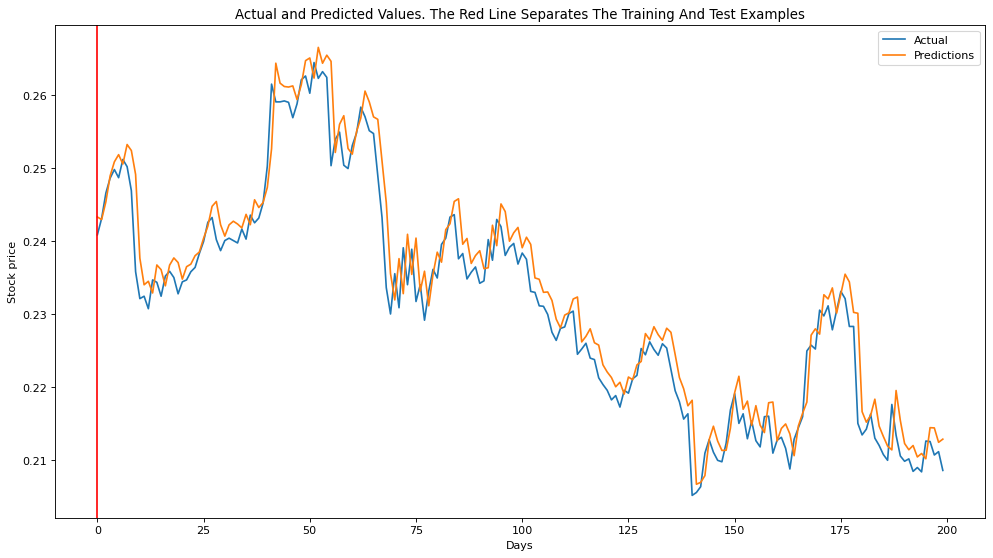

In [54]:
# Plotting actual stock prices and predictions
with tf.device('/cpu:0'):
    train_predict_optimized_lstm_2 = fitted_optimized_lstm_2.model.predict(
        X_train)
    val_predict_optimized_lstm_2 = fitted_optimized_lstm_2.model.predict(X_val)
# plot_result(y_train, y_val, train_predict_optimized_lstm_2,
#             val_predict_optimized_lstm_2)
plot_result(np.array([]), y_val[500:700], np.array([]),
            val_predict_optimized_lstm_2[500:700])


### Performance metrics

In [46]:
# Get training and validation MSEs for all variations of the RNN
train_mse_simple_lstm, val_mse_simple_lstm = mean_squared_error(
    y_train.reshape(y_train.shape[0], 1), train_predict_simple_lstm), mean_squared_error(y_val.reshape(y_val.shape[0], 1), val_predict_simple_lstm)

train_mse_lstm_1, val_mse_lstm_1 = mean_squared_error(
    y_train.reshape(y_train.shape[0], 1), train_predict_lstm_1), mean_squared_error(y_val.reshape(y_val.shape[0], 1), val_predict_lstm_1)

train_mse_optimized_lstm_2, val_mse_optimized_lstm_2 = mean_squared_error(
    y_train.reshape(y_train.shape[0], 1), train_predict_optimized_lstm_2), mean_squared_error(y_val.reshape(y_val.shape[0], 1), val_predict_optimized_lstm_2)


In [47]:
lstm_summary = [("Simple LSTM", train_mse_simple_lstm, val_mse_simple_lstm),
               ("Stacked LSTM", train_mse_lstm_1, val_mse_lstm_1),
               ("Optimized stacked LSTM", train_mse_optimized_lstm_2, val_mse_optimized_lstm_2)]

lstm_summary_df = pd.DataFrame(
    lstm_summary, columns=["Model", "Train MSE", "Val MSE"])
lstm_summary_df


,Model,Train MSE,Val MSE
0,Simple LSTM,0.000044,0.000029
1,Stacked LSTM,0.000034,0.000024
2,Optimized simple LSTM,0.000033,0.000026


### Experimenting with window size

(7479, 50, 1) (7479, 1, 1)
(2460, 50, 1) (2460, 1, 1)
Epoch 1/10


2022-11-20 19:27:07.084128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


234/234 [==============================] - ETA: 0s - loss: 8.5987e-04

2022-11-20 19:27:18.019457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


234/234 [==============================] - 13s 48ms/step - loss: 8.5987e-04 - val_loss: 2.1783e-04
Epoch 2/10
234/234 [==============================] - 11s 45ms/step - loss: 3.0736e-04 - val_loss: 1.3016e-04
Epoch 3/10
234/234 [==============================] - 11s 47ms/step - loss: 2.1550e-04 - val_loss: 1.0420e-04
Epoch 4/10
234/234 [==============================] - 11s 48ms/step - loss: 1.8372e-04 - val_loss: 2.6247e-04
Epoch 5/10
234/234 [==============================] - 11s 46ms/step - loss: 1.8324e-04 - val_loss: 7.7742e-05
Epoch 6/10
234/234 [==============================] - 11s 46ms/step - loss: 1.2339e-04 - val_loss: 7.4091e-05
Epoch 7/10
234/234 [==============================] - 11s 47ms/step - loss: 1.1070e-04 - val_loss: 1.9840e-04
Epoch 8/10
234/234 [==============================] - 11s 47ms/step - loss: 1.0115e-04 - val_loss: 1.3532e-04
Epoch 9/10
234/234 [==============================] - 11s 47ms/step - loss: 9.5757e-05 - val_loss: 5.5419e-05
Epoch 10/10
234/234 [

2022-11-20 19:28:58.165207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


77/77 [==============================] - 1s 13ms/step


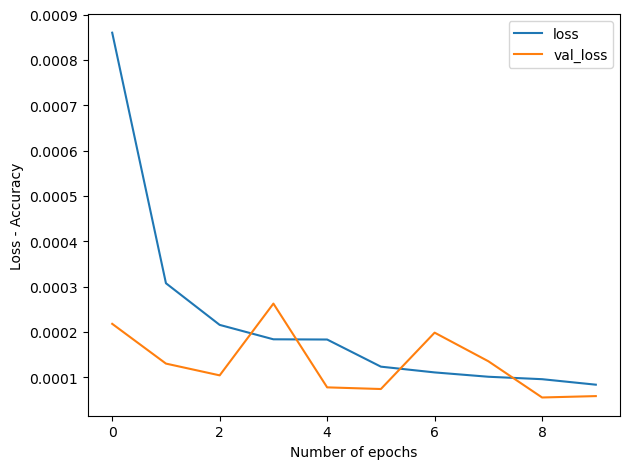

Val MSE = 5.8473750395064324e-05
(7429, 100, 1) (7429, 1, 1)
(2410, 100, 1) (2410, 1, 1)
Epoch 1/10


2022-11-20 19:29:06.810629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


233/233 [==============================] - ETA: 0s - loss: 7.8541e-04

2022-11-20 19:29:26.762241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


233/233 [==============================] - 23s 90ms/step - loss: 7.8541e-04 - val_loss: 1.5274e-04
Epoch 2/10
233/233 [==============================] - 20s 87ms/step - loss: 3.1275e-04 - val_loss: 2.7714e-04
Epoch 3/10
233/233 [==============================] - 20s 86ms/step - loss: 2.1576e-04 - val_loss: 9.0293e-05
Epoch 4/10
233/233 [==============================] - 20s 87ms/step - loss: 2.0119e-04 - val_loss: 8.2690e-05
Epoch 5/10
233/233 [==============================] - 20s 86ms/step - loss: 1.4045e-04 - val_loss: 2.4419e-04
Epoch 6/10
233/233 [==============================] - 20s 87ms/step - loss: 1.2303e-04 - val_loss: 6.6777e-05
Epoch 7/10
233/233 [==============================] - 20s 87ms/step - loss: 9.8946e-05 - val_loss: 5.2189e-05
Epoch 8/10
233/233 [==============================] - 20s 87ms/step - loss: 9.9588e-05 - val_loss: 1.4387e-04
Epoch 9/10
233/233 [==============================] - 20s 87ms/step - loss: 1.2464e-04 - val_loss: 5.5479e-05
Epoch 10/10
233/233 [

2022-11-20 19:32:31.036447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


76/76 [==============================] - 2s 22ms/step


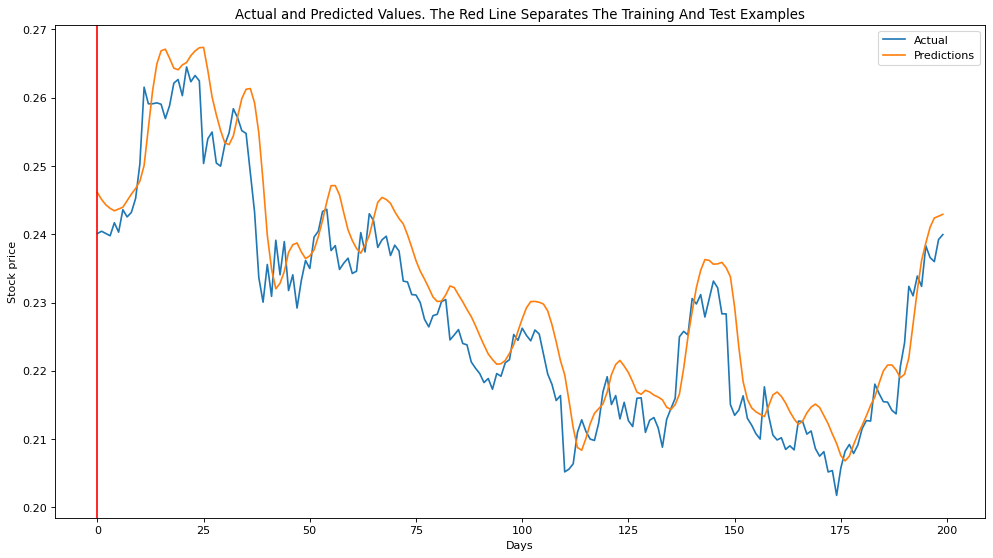

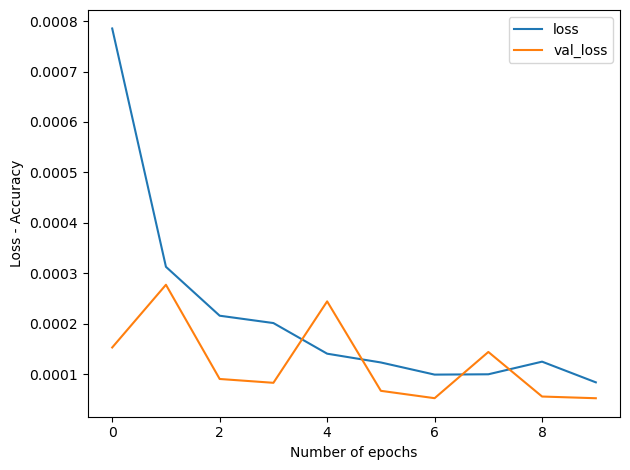

Val MSE = 5.209601322214171e-05


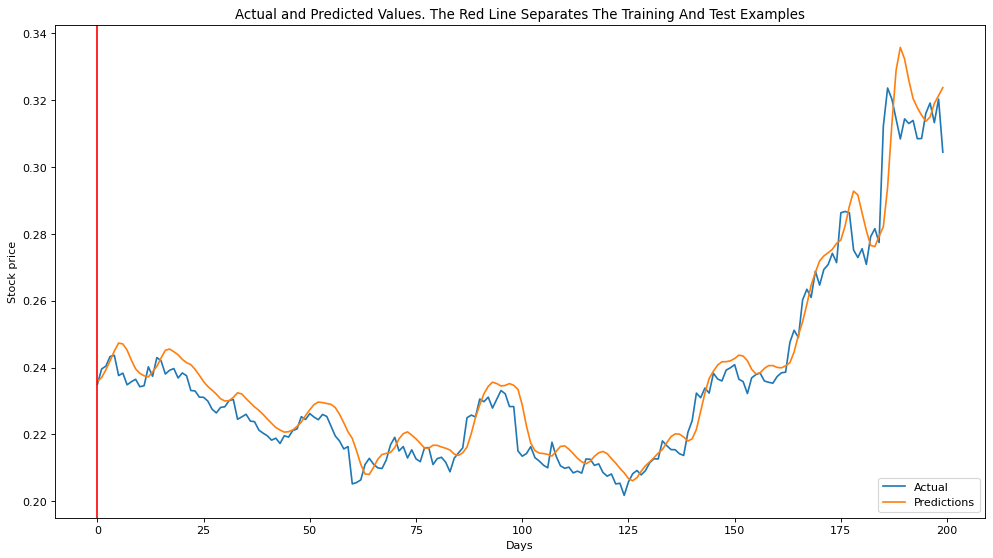

In [53]:
# Get the train features, train labels, test features, test labels
train_sizes = [50, 100]
label_count = 1

for train_size in train_sizes:
    X_train_e, y_train_e = get_data_splits(
        training_set, train_size, label_count)
    X_val_e, y_val_e = get_data_splits(
        validation_set, train_size, label_count)

    print(X_train_e.shape, y_train_e.shape)
    print(X_val_e.shape, y_val_e.shape)

    model = create_LSTM_1([n_hidden_units, n_hidden_units, n_hidden_units], n_dense_units,
                               (train_size, 1), activation='tanh')
    with tf.device('/cpu:0'):
        fitted_model = model.fit(X_train_e, y_train_e, validation_data=(
            X_val_e, y_val_e), batch_size=BATCH_SIZE, epochs=EPOCH_COUNT - 30)
        train_predict = fitted_model.model.predict(X_train_e)
        val_predict = fitted_model.model.predict(X_val_e)
    # Plotting actual stock prices and predictions
    plot_training_history(fitted_model)
    plot_result(np.array([]), y_val_e[500:700],
                np.array([]), val_predict[500:700])
    print("Val MSE =", mean_squared_error(
        y_val_e.reshape(y_val_e.shape[0], 1), val_predict))
